In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import os
from PIL import Image
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from datasets import utils
from tqdm import tqdm

In [ ]:
!nvidia-smi

Sat Nov 23 00:46:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0              40W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def setup_seed(seed=2021):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Colab GPU Information
- T4 (**15 GB not enough**) :
  - **RAM**: 15.0 GB
  - **Compute**:  1.58 per hour
- L4:
  - **RAM**: 22.5 GB
  - **Compute**: 3 per hour
- A100:
  - **RAM**: 40.0 GB
  - **Compute**:  10.59 per hour

# Setting Paths
I'm putting all the paths here, so just change them here and everything should work correctly.

In [ ]:
import torchvision.datasets as datasets

In [ ]:
if 'COLAB_GPU' in os.environ:
    from google.colab import drive
    drive.mount('/content/drive')
elif "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
    # The base ESRGAN model .pth file
    load_model_base_path = "/kaggle/input/aai3001-large-project-models/original/ESRGAN_4x.pth"
    # The .pth file that we generated
    load_model_trained_path = "/kaggle/input/aai3001-large-project-models/MSELoss/large-02-22-11-24-epoch10.pth"
    # Where we should save our best model
    save_best_model_path = "/kaggle/working/best_model.pth"
    save_model_base_path = "/kaggle/working/model_epoch.pth"
    # Dataset
    dataset_pd_path = "/kaggle/input/aai3001-large-project/paths.csv"
    dataset_root_dir = "/kaggle/input/aai3001-large-project"
    # The directory that the ZIP file should be saved to
    ZIP_file_output_dir = "/kaggle/working"

Mounted at /content/drive


In [ ]:
if 'COLAB_GPU' in os.environ:
    ROOT = '/content'
    DATA_ROOT = '/content/data'
    MODEL_ROOT = '/content/model'
    drive_data_zip_path = "/content/drive/MyDrive/SIT Y2TRI1/AAI3001 Machine Vision/data.zip"
    drive_model_zip_path = "/content/drive/MyDrive/SIT Y2TRI1/AAI3001 Machine Vision/models.zip"

    if not os.path.isdir(DATA_ROOT):
        os.mkdir(DATA_ROOT)
    datasets.utils.extract_archive(drive_data_zip_path, DATA_ROOT)
    if not os.path.isdir(MODEL_ROOT):
        os.mkdir(MODEL_ROOT)
    datasets.utils.extract_archive(drive_model_zip_path, MODEL_ROOT)

In [ ]:
if 'COLAB_GPU' in os.environ:
    # The base ESRGAN model .pth file
    load_model_base_path = "/content/model/original/ESRGAN_4x.pth"
    # The .pth file that we generated
    load_model_trained_path = "/content/model/MSELoss/large-02-22-11-24-epoch10.pth"
    # Where we should save our best model
    save_best_model_path = "/content/output/best_model.pth"
    save_model_base_path = "/content/output/model_epoch.pth"
    # Dataset
    dataset_pd_path = "/content/data/paths.csv"
    dataset_root_dir = "/content/data/"
    # The directory that the ZIP file should be saved to
    OUTPUT_ROOT = '/content/output'
    if not os.path.isdir(OUTPUT_ROOT):
        os.mkdir(OUTPUT_ROOT)
    ZIP_file_output_dir = OUTPUT_ROOT

# Load Data

In [ ]:
import random

class ImageDataset(Dataset):
    def __init__(self, img_type, lowres_transform=None, highres_transform=None):
        self.data = pd.read_csv(dataset_pd_path)
        self.data = self.data[self.data['type'] == img_type]  # Filter by 'TRAIN', 'TEST', or 'VAL'
        self.root_dir = dataset_root_dir
        self.transform = lowres_transform
        self.highres_transform = highres_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load high and low resolution images
        # stored paths are read as '\\'. I'm just changing it to '/' so it matches kaggle paths
        highres_path = self.root_dir + '/' + self.data.iloc[idx, 0].replace("\\", '/')
        # print(highres_path)
        lowres_path = self.root_dir + '/' + self.data.iloc[idx, 1].replace("\\", '/')

        highres_img = Image.open(highres_path).convert("RGB")
        lowres_img = Image.open(lowres_path).convert("RGB")

        if self.transform:
            lowres_img = self.transform(lowres_img)
        if self.highres_transform:
            highres_img = self.highres_transform(highres_img)

        return highres_img, lowres_img  # Returns both lowres and highres images

    def getpath(self, idx):
        # Load high and low resolution images
        # stored paths are read as '\\'. I'm just changing it to '/' so it matches kaggle paths
        highres_path = self.root_dir + '/' + self.data.iloc[idx, 0].replace("\\", '/')
        # print(highres_path)
        lowres_path = self.root_dir + '/' + self.data.iloc[idx, 1].replace("\\", '/')

        return highres_path, lowres_path  # Returns both lowres and highres images

In [ ]:
# Just adding this in case we want to test on smaller images
TRAIN_LARGE = True

if TRAIN_LARGE:
    lowres_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    highres_transform = transforms.Compose([
        transforms.Resize((1024, 1024)),
        transforms.ToTensor()
    ])
else:
    lowres_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])
    highres_transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])

In [ ]:
from torch.utils.data import Subset
import numpy as np

train_dataset = ImageDataset(img_type='TRAIN', lowres_transform=lowres_transform, highres_transform=highres_transform)
test_dataset = ImageDataset(img_type='TEST', lowres_transform=lowres_transform, highres_transform=highres_transform)

def get_subset(dataset, subset_size):
    total_items = len(dataset)
    subset_indices = np.random.choice(total_items, subset_size, replace=False)
    subset = Subset(dataset, subset_indices)
    return subset

# train_dataset = get_subset(train_dataset, 200)
# test_dataset = get_subset(test_dataset, 100)

In [ ]:
if 'COLAB_GPU' in os.environ:
  if TRAIN_LARGE:
      train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, pin_memory=True)
      test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, pin_memory=True)
      print("Loading For Large Model")
  else:
      train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True)
      test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, pin_memory=True)
      print("Loading For Small Model")
elif "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
  if TRAIN_LARGE:
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, pin_memory=True)
    print("Loading For Large Model")
  else:
    train_loader = DataLoader(train_subset, batch_size=4, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_subset, batch_size=2, shuffle=True, pin_memory=True)
    print("Loading For Small Model")

print(f"Train Size: {len(train_dataset)}")
print(f"Test Size: {len(test_dataset)}")

Loading For Small Model
Train Size: 10964
Test Size: 2431


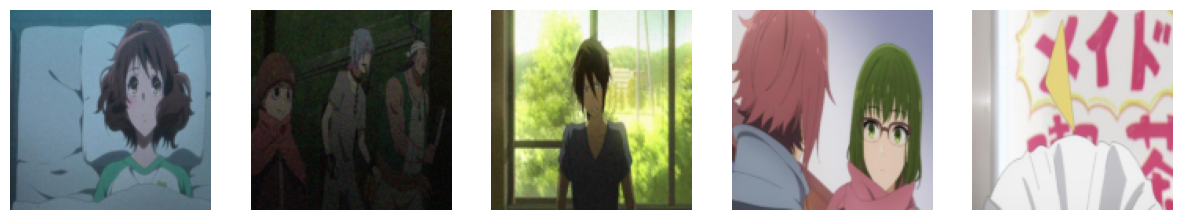

In [ ]:
# Set up the figure with 5 random images
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for ax in axs:
    # Randomly select an index
    idx = random.randint(0, len(train_dataset) - 1)

    # Load the images
    highres_img, lowres_img = train_dataset[idx]

    # Convert the tensor to an image for display
    lowres_img_pil = transforms.ToPILImage()(lowres_img)

    # Display the low-resolution image
    ax.imshow(lowres_img_pil)
    ax.axis('off')  # Turn off axis for better visualization

plt.show()

# ESRGAN_4x

In [ ]:
import torch
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms

## Loading the Model
model pulled from [here](https://github.com/xinntao/ESRGAN)

In [ ]:
import functools
import torch
import torch.nn as nn
import torch.nn.functional as F


def make_layer(block, n_layers):
    layers = []
    for _ in range(n_layers):
        layers.append(block())
    return nn.Sequential(*layers)


class ResidualDenseBlock_5C(nn.Module):
    def __init__(self, nf=64, gc=32, bias=True):
        super(ResidualDenseBlock_5C, self).__init__()
        # gc: growth channel, i.e. intermediate channels
        self.conv1 = nn.Conv2d(nf, gc, 3, 1, 1, bias=bias)
        self.conv2 = nn.Conv2d(nf + gc, gc, 3, 1, 1, bias=bias)
        self.conv3 = nn.Conv2d(nf + 2 * gc, gc, 3, 1, 1, bias=bias)
        self.conv4 = nn.Conv2d(nf + 3 * gc, gc, 3, 1, 1, bias=bias)
        self.conv5 = nn.Conv2d(nf + 4 * gc, nf, 3, 1, 1, bias=bias)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # initialization
        # mutil.initialize_weights([self.conv1, self.conv2, self.conv3, self.conv4, self.conv5], 0.1)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        return x5 * 0.2 + x


class RRDB(nn.Module):
    '''Residual in Residual Dense Block'''
    def __init__(self, nf, gc=32):
        super(RRDB, self).__init__()
        self.RDB1 = ResidualDenseBlock_5C(nf, gc)
        self.RDB2 = ResidualDenseBlock_5C(nf, gc)
        self.RDB3 = ResidualDenseBlock_5C(nf, gc)

    def forward(self, x):
        out = self.RDB1(x)
        out = self.RDB2(out)
        out = self.RDB3(out)
        return out * 0.2 + x


class RRDBNet(nn.Module):
    def __init__(self, in_nc, out_nc, nf, nb, gc=32):
        super(RRDBNet, self).__init__()
        RRDB_block_f = functools.partial(RRDB, nf=nf, gc=gc)

        self.conv_first = nn.Conv2d(in_nc, nf, 3, 1, 1, bias=True)
        self.RRDB_trunk = make_layer(RRDB_block_f, nb)
        self.trunk_conv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        #### upsampling
        self.upconv1 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.upconv2 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.HRconv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.conv_last = nn.Conv2d(nf, out_nc, 3, 1, 1, bias=True)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        fea = self.conv_first(x)
        trunk = self.trunk_conv(self.RRDB_trunk(fea))
        fea = fea + trunk

        fea = self.lrelu(self.upconv1(F.interpolate(fea, scale_factor=2, mode='nearest')))
        fea = self.lrelu(self.upconv2(F.interpolate(fea, scale_factor=2, mode='nearest')))
        out = self.conv_last(self.lrelu(self.HRconv(fea)))

        return out

In [ ]:
def load_ESRGAN(model_path=None):
    # Create an instance of the model
    model = RRDBNet(3, 3, 64, 23)
    model.to(device)
    model.eval()

    # Load the model without checkpoint=
    try:
        if model_path is None:
            checkpoint = torch.load(load_model_base_path, map_location=torch.device('cpu'), weights_only=False)
        else:
            checkpoint = torch.load(model_path, map_location=torch.device('cpu'), weights_only=False)

        model.load_state_dict(checkpoint, strict=False)  # Load weights, allow missing keys
        print(f"Model {model_path} loaded successfully.")
    except Exception as e:
        print(f"Error loading the model: {e}")

    return model

In [ ]:
esrgan_model = load_ESRGAN()

Model None loaded successfully.


# Testing Models

In [ ]:
import zipfile

In [ ]:
def generate_images(model):
    model.eval()

    fig, axs = plt.subplots(NUM_IMAGES, 3, figsize=(15, 4 * NUM_IMAGES))
    for i, idx in enumerate(tqdm(random_indices, desc="Testing model...")):
        highres_image, lowres_image = train_dataset[idx]
        lowres_img_pil = transforms.ToPILImage()(lowres_image)
        highres_img_pil = transforms.ToPILImage()(highres_image)

        input_tensor = lowres_image.unsqueeze(0).to(device)  # Add batch dimension

        # Test the model with the input image and upscale by x4
        with torch.no_grad():
            # Upscaling by x4
            output = model(input_tensor)
            output = torch.clamp(output, 0, 1)  # Clamp directly to [0, 1] without shifting
            output_image = transforms.ToPILImage()(output.squeeze(0))  # Convert back to PIL

        # Render Images
        axs[i, 0].imshow(lowres_img_pil)
        axs[i, 0].set_title("Low Resolution")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(highres_img_pil)
        axs[i, 1].set_title("High Resolution")
        axs[i, 1].axis('off')

        axs[i, 2].imshow(output_image)
        axs[i, 2].set_title("Output Image")
        axs[i, 2].axis('off')

In [ ]:
NUM_IMAGES = 5
random_indices = random.sample(range(len(train_dataset)), NUM_IMAGES)

Testing model...: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


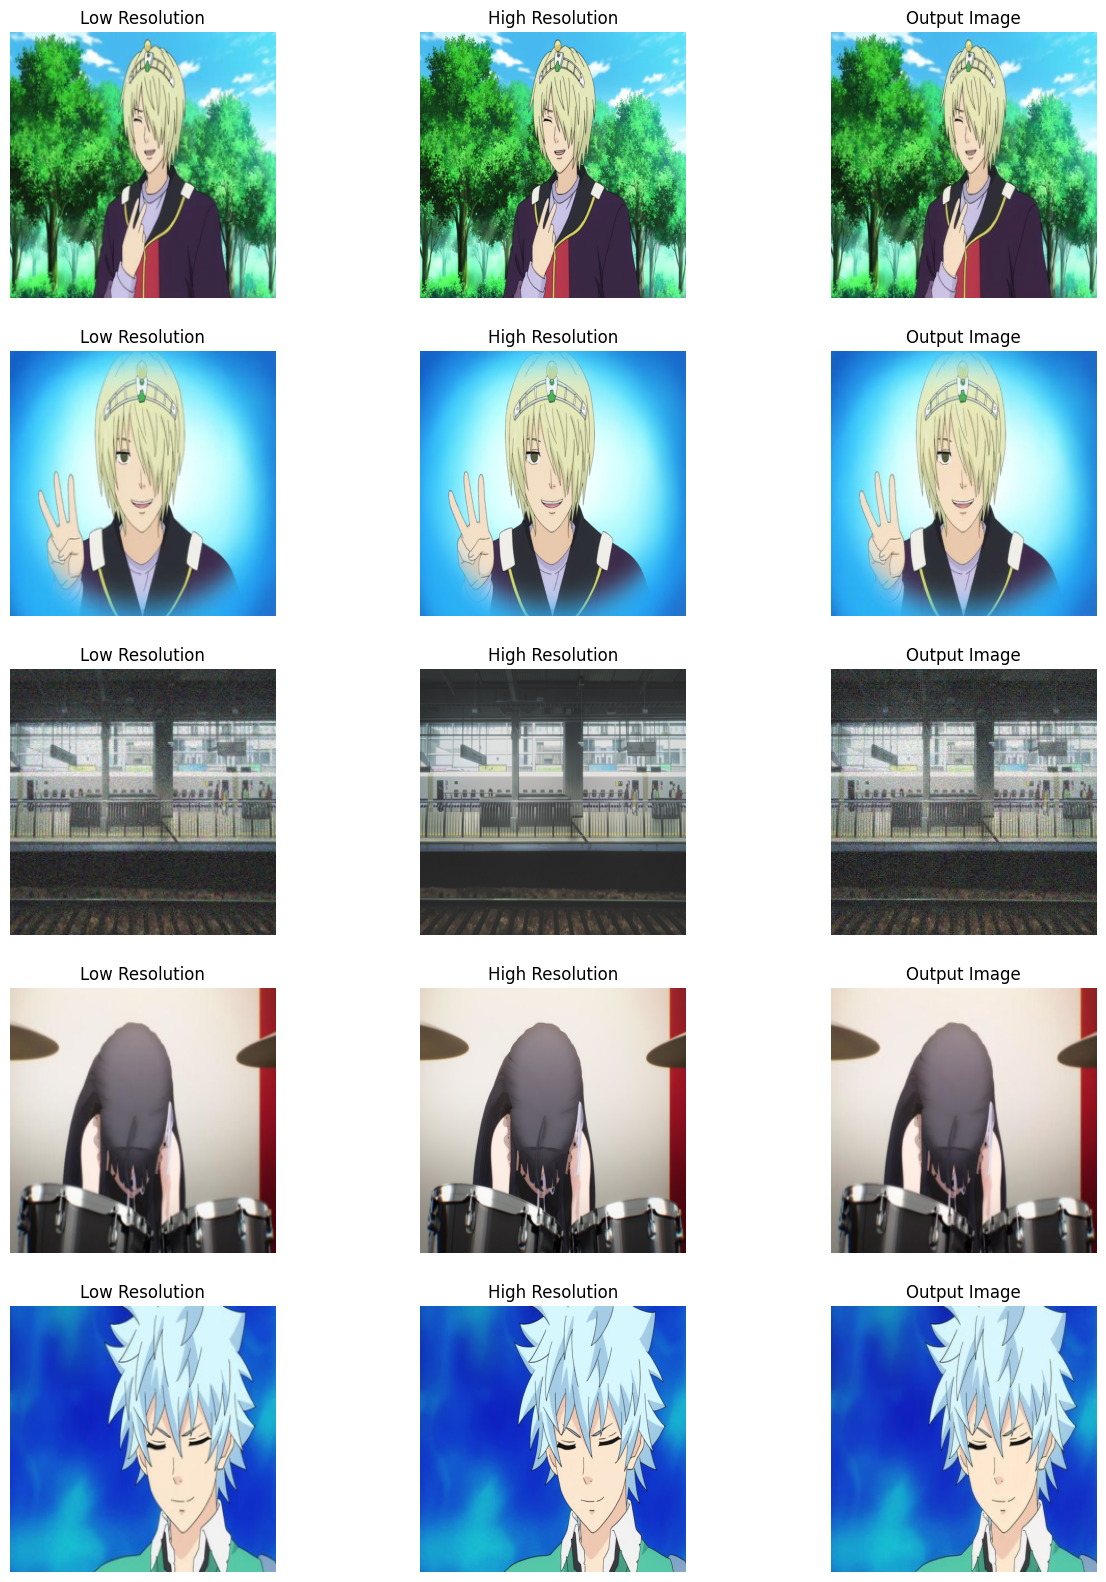

In [ ]:
generate_images(esrgan_model)

# Training the Model

## Train & Test

In [ ]:
from torch.cuda.amp import autocast, GradScaler

def train_epoch(model, device, dataloader, criterion, optimizer, epoch=0):
    model.train()
    model.to(device)
    desc_msg = f"Training..."
    if epoch != 0:
        desc_msg = f"Training Epoch {epoch}..."

    running_loss = 0
    for highres, lowres in tqdm(dataloader, desc=desc_msg):
        highres, lowres = highres.to(device), lowres.to(device)

        # Forward Pass
        optimizer.zero_grad()

        output = model(lowres)

        # Compute Loss
        loss = criterion(highres, output)
        running_loss += loss.item()

        # Backward Pass
        loss.backward()
        optimizer.step()

    return running_loss

In [ ]:
def test_epoch(model, device, dataloader, criterion, optimizer, epoch=1):
    model.eval()
    model.to(device)
    desc_msg = f"Training..."
    if epoch != 0:
        desc_msg = f"Testing Epoch {epoch}..."

    running_loss = 0
    num_batches = len(dataloader)

    with torch.no_grad():
        for highres, lowres in tqdm(dataloader, desc=desc_msg):
            highres, lowres = highres.to(device), lowres.to(device)

            # Forward Pass
            output = model(lowres)

            # Compute Loss
            loss = criterion(highres, output)
            running_loss += loss.item()

    return running_loss

## Setting up Model, Loss, and Optimizer

In [ ]:
import torch.nn as nn
from torchvision import models

In [ ]:
NUM_EPOCHS = 75
LOAD_TRAINED = True
lr = 1e-4

if not LOAD_TRAINED:
    final_model = load_ESRGAN()
    print("Loaded Base Model")
else:
    final_model = load_ESRGAN(load_model_trained_path)
    print("Loaded Trained Model")

optimizer = torch.optim.Adam(final_model.parameters(), lr=lr, betas=(0.9, 0.999))

# loss_func = nn.L1Loss()
loss_func = nn.MSELoss()

Model None loaded successfully.
Loaded Base Model


## Create ZIP with images from Base and Trained Model

In [ ]:
def generate_output(base_model, trained_model, dataset, img_count=10):
    # Set models to eval mode
    base_model.eval()
    trained_model.eval()

    # Create new folder to store generated images and high res images
    source_img_folder = "imgs_comparison"
    img_subfolder_path = os.path.join(ZIP_file_output_dir, source_img_folder)
    if not os.path.exists(img_subfolder_path):
        os.makedirs(img_subfolder_path)
    # Choose random images
    random_indices = random.sample(range(len(dataset)), img_count)

    zip_filename = os.path.join(ZIP_file_output_dir, "output_comparison.zip")
    # Zip generated files
    with zipfile.ZipFile(zip_filename, 'w')  as zipf:
        for i, idx in enumerate(tqdm(random_indices, desc="Generating Comparison Images...")):
            # Load images
            highres_image, lowres_image = dataset[idx]
            lowres_img_pil = transforms.ToPILImage()(lowres_image)
            highres_img_pil = transforms.ToPILImage()(highres_image)
            input_tensor = lowres_image.unsqueeze(0).to(device)  # Add batch dimension

            # Test the model with the input image and upscale by x4
            with torch.no_grad():
                # Base Model
                output_base = base_model(input_tensor)
                output_base = torch.clamp(output_base, 0, 1)  # Clamp directly to [0, 1] without shifting
                output_base_image_pil = transforms.ToPILImage()(output_base.squeeze(0))  # Convert back to PIL

                # Trained Model
                output_trained = trained_model(input_tensor)
                output_trained = torch.clamp(output_trained, 0, 1)  # Clamp directly to [0, 1] without shifting
                output_trained_image_pil = transforms.ToPILImage()(output_trained.squeeze(0))  # Convert back to PIL

            # Save generated images

            lowres_img_path = os.path.join(img_subfolder_path, f"img{i:02d}_1_lowres.png")
            lowres_img_pil.save(lowres_img_path)
            zipf.write(lowres_img_path, os.path.basename(lowres_img_path))

            og_img_path = os.path.join(img_subfolder_path, f"img{i:02d}_2_highres.png")
            highres_img_pil.save(og_img_path)
            zipf.write(og_img_path, os.path.basename(og_img_path))

            base_img_path = os.path.join(img_subfolder_path, f"img{i:02d}_3_base.png")
            output_base_image_pil.save(base_img_path)
            zipf.write(base_img_path, os.path.basename(base_img_path))

            trained_img_path = os.path.join(img_subfolder_path, f"img{i:02d}_4_trained.png")
            output_trained_image_pil.save(trained_img_path)
            zipf.write(trained_img_path, os.path.basename(trained_img_path))

    print("Done!")

In [ ]:
# Doing this just to make sure we are starting with the right model
generate_output(esrgan_model, final_model, test_dataset, 30)

Generating Comparison Images...: 100%|██████████| 30/30 [00:37<00:00,  1.25s/it]

Done!


## Training

In [ ]:
best_loss = float('inf')
patience = 7  # Number of epochs to wait for improvement
epochs_no_improve = 0  # Counter for epochs with no improvement

train_losses = []
test_losses = []

torch.cuda.empty_cache()
for epoch in range(1, NUM_EPOCHS + 1):
    # TRAIN
    train_loss = train_epoch(final_model, device, train_loader, loss_func, optimizer, epoch)
    train_losses.append(train_loss)

    # TEST
    test_loss = test_epoch(final_model, device, test_loader, loss_func, optimizer, epoch)
    test_losses.append(test_loss)
    print(f"Epoch [{epoch:02d}/{NUM_EPOCHS:02d}, Training Loss: {train_loss:.4f}]")
    print(f"Epoch [{epoch:02d}/{NUM_EPOCHS:02d}, Test Loss: {test_loss:.4f}]")

    # Save current epoch
    model_path = save_model_base_path.split('.')[0] + f"{epoch}." + save_model_base_path.split('.')[1]
    torch.save(final_model.state_dict(), model_path)

    # Check if this is the best validation loss so far
    if test_loss < best_loss:
        best_loss = test_loss
        epochs_no_improve = 0
        # Save the model checkpoint
        torch.save(final_model.state_dict(), save_best_model_path)
        print(f"New best model saved with validation loss: {best_loss:.8f}")
    else:
        epochs_no_improve += 1

    # Check for early stopping
    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch} due to no improvement in validation loss for {patience} consecutive epochs.")
        break

    print("")

Testing Epoch 1...: 100%|██████████| 304/304 [01:58<00:00,  2.56it/s]


Epoch [01/75, Training Loss: 0.8931]
Epoch [01/75, Test Loss: 0.1868]
New best model saved with validation loss: 0.18677508



Testing Epoch 2...: 100%|██████████| 304/304 [01:57<00:00,  2.59it/s]


Epoch [02/75, Training Loss: 0.8050]
Epoch [02/75, Test Loss: 0.1794]
New best model saved with validation loss: 0.17939801



Testing Epoch 3...: 100%|██████████| 304/304 [01:57<00:00,  2.59it/s]


Epoch [03/75, Training Loss: 0.7742]
Epoch [03/75, Test Loss: 0.1758]
New best model saved with validation loss: 0.17578969



Testing Epoch 4...: 100%|██████████| 304/304 [01:57<00:00,  2.59it/s]


Epoch [04/75, Training Loss: 0.7493]
Epoch [04/75, Test Loss: 0.1719]
New best model saved with validation loss: 0.17194391



Testing Epoch 5...: 100%|██████████| 304/304 [01:57<00:00,  2.60it/s]


Epoch [05/75, Training Loss: 0.7329]
Epoch [05/75, Test Loss: 0.1710]
New best model saved with validation loss: 0.17099998



Testing Epoch 6...: 100%|██████████| 304/304 [01:58<00:00,  2.56it/s]


Epoch [06/75, Training Loss: 0.7154]
Epoch [06/75, Test Loss: 0.1693]
New best model saved with validation loss: 0.16931574



Testing Epoch 7...: 100%|██████████| 304/304 [01:58<00:00,  2.57it/s]


Epoch [07/75, Training Loss: 0.7040]
Epoch [07/75, Test Loss: 0.1675]
New best model saved with validation loss: 0.16753239



Testing Epoch 8...: 100%|██████████| 304/304 [01:57<00:00,  2.59it/s]


Epoch [08/75, Training Loss: 0.6937]
Epoch [08/75, Test Loss: 0.1676]



Testing Epoch 9...: 100%|██████████| 304/304 [02:03<00:00,  2.46it/s]


Epoch [09/75, Training Loss: 0.6820]
Epoch [09/75, Test Loss: 0.1683]



Testing Epoch 10...: 100%|██████████| 304/304 [01:59<00:00,  2.55it/s]


Epoch [10/75, Training Loss: 0.6720]
Epoch [10/75, Test Loss: 0.1662]
New best model saved with validation loss: 0.16616688



Testing Epoch 11...: 100%|██████████| 304/304 [02:02<00:00,  2.48it/s]


Epoch [11/75, Training Loss: 0.6663]
Epoch [11/75, Test Loss: 0.1660]
New best model saved with validation loss: 0.16597622



Testing Epoch 12...: 100%|██████████| 304/304 [02:02<00:00,  2.48it/s]


Epoch [12/75, Training Loss: 0.6575]
Epoch [12/75, Test Loss: 0.1667]



Testing Epoch 13...: 100%|██████████| 304/304 [01:57<00:00,  2.60it/s]


Epoch [13/75, Training Loss: 0.6488]
Epoch [13/75, Test Loss: 0.1650]
New best model saved with validation loss: 0.16495886



Testing Epoch 14...: 100%|██████████| 304/304 [01:56<00:00,  2.60it/s]


Epoch [14/75, Training Loss: 0.6404]
Epoch [14/75, Test Loss: 0.1670]



Testing Epoch 15...: 100%|██████████| 304/304 [02:01<00:00,  2.51it/s]


Epoch [15/75, Training Loss: 0.6348]
Epoch [15/75, Test Loss: 0.1644]
New best model saved with validation loss: 0.16437432



Testing Epoch 16...: 100%|██████████| 304/304 [01:57<00:00,  2.59it/s]


Epoch [16/75, Training Loss: 0.6298]
Epoch [16/75, Test Loss: 0.1639]
New best model saved with validation loss: 0.16385904



Testing Epoch 17...: 100%|██████████| 304/304 [01:57<00:00,  2.59it/s]


Epoch [17/75, Training Loss: 0.6213]
Epoch [17/75, Test Loss: 0.1651]



Testing Epoch 18...: 100%|██████████| 304/304 [01:56<00:00,  2.60it/s]


Epoch [18/75, Training Loss: 0.6146]
Epoch [18/75, Test Loss: 0.1640]



Testing Epoch 19...: 100%|██████████| 304/304 [01:58<00:00,  2.58it/s]


Epoch [19/75, Training Loss: 0.6093]
Epoch [19/75, Test Loss: 0.1638]
New best model saved with validation loss: 0.16376116



Testing Epoch 20...: 100%|██████████| 304/304 [01:56<00:00,  2.60it/s]


Epoch [20/75, Training Loss: 0.6048]
Epoch [20/75, Test Loss: 0.1643]



Testing Epoch 21...: 100%|██████████| 304/304 [01:57<00:00,  2.59it/s]


Epoch [21/75, Training Loss: 0.6002]
Epoch [21/75, Test Loss: 0.1627]
New best model saved with validation loss: 0.16270392



Testing Epoch 22...: 100%|██████████| 304/304 [01:57<00:00,  2.58it/s]


Epoch [22/75, Training Loss: 0.5930]
Epoch [22/75, Test Loss: 0.1640]



Testing Epoch 23...: 100%|██████████| 304/304 [01:57<00:00,  2.60it/s]


Epoch [23/75, Training Loss: 0.5908]
Epoch [23/75, Test Loss: 0.1643]



Testing Epoch 24...: 100%|██████████| 304/304 [01:57<00:00,  2.59it/s]


Epoch [24/75, Training Loss: 0.5870]
Epoch [24/75, Test Loss: 0.1651]



Testing Epoch 25...: 100%|██████████| 304/304 [02:01<00:00,  2.51it/s]


Epoch [25/75, Training Loss: 0.5797]
Epoch [25/75, Test Loss: 0.1649]



Testing Epoch 26...: 100%|██████████| 304/304 [01:58<00:00,  2.57it/s]


Epoch [26/75, Training Loss: 0.5787]
Epoch [26/75, Test Loss: 0.1659]



Training Epoch 27...:   5%|▍         | 65/1371 [00:45<15:20,  1.42it/s]

In [ ]:
generate_images(final_model)

In [ ]:
# Saving images to compare upscaling
generate_output(esrgan_model, final_model, test_dataset, 20)

# Plotting Loss

In [ ]:
epochs = list(range(1, len(train_losses) + 1))

# Plotting train and test losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
val_dataset = ImageDataset(img_type='VAL', lowres_transform=lowres_transform, highres_transform=highres_transform)
val_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, pin_memory=True)


val_loss = test_epoch(final_model, device, val_loader, loss_func, optimizer, 0)
printf(f"Final Loss: {val_loss}")